In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import itertools
import warnings

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore") 

In [2]:
df = pd.read_csv("data/[1h]BTCUSDT.csv", 
                 parse_dates=['Start', 'Stop'], 
                 date_parser=lambda x: datetime.datetime.fromtimestamp(float(x)/1000))
df.columns = ["start", "stop", "open", "close", "high", "low", "volume"]

In [3]:
df.head()

,start,stop,open,close,high,low,volume
0,2017-08-17 07:00:00,2017-08-17 07:59:59.999,4261.48,4308.83,4261.32,4313.62,47.181009
1,2017-08-17 08:00:00,2017-08-17 08:59:59.999,4308.83,4315.32,4291.37,4328.69,23.234916
2,2017-08-17 09:00:00,2017-08-17 09:59:59.999,4330.29,4324.35,4309.37,4345.45,7.229691
3,2017-08-17 10:00:00,2017-08-17 10:59:59.999,4316.62,4349.99,4287.41,4349.99,4.443249
4,2017-08-17 11:00:00,2017-08-17 11:59:59.999,4333.32,4360.69,4333.32,4377.85,0.972807


### ARMA

In [4]:
p = q = range(0, 3)

pdq = list(itertools.product(p, q))

delta = np.inf

for param in pdq:
    try:
        mod = ARIMA(df.open[::100],
                        order=(param[0], 0 ,param[1]),
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        results = mod.fit()

        if results.aic < delta:
                delta = results.aic
                arma_param = param
    except:
        continue

arma_param = (arma_param[0], 0, arma_param[1])

In [5]:
print("param = {0}".format(arma_param))

param = (1, 0, 2)


RMSE: 506.95110683726153


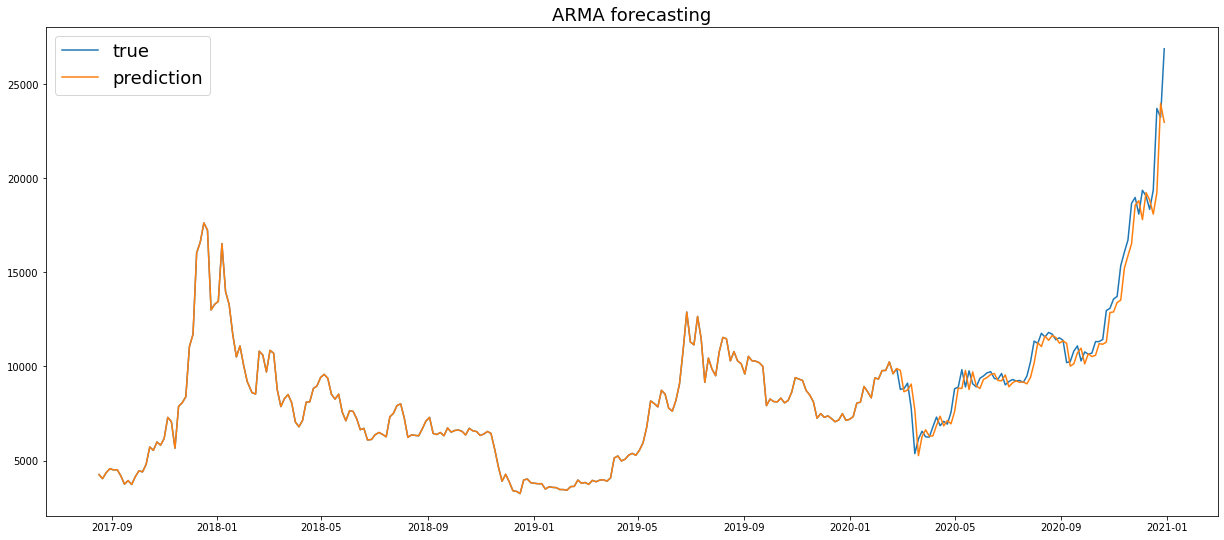

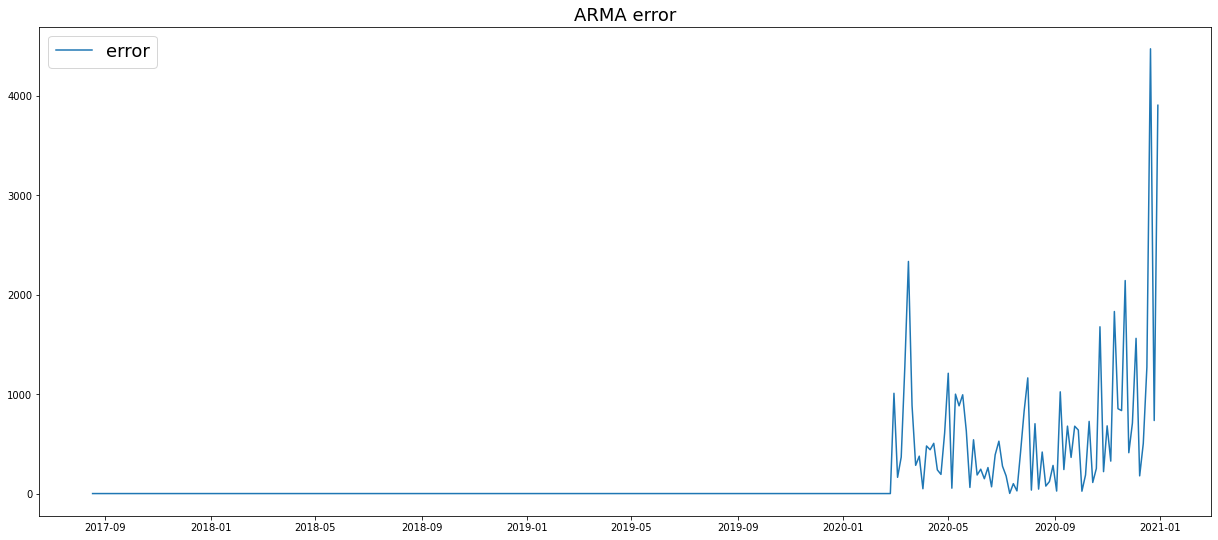

In [6]:
train, test = train_test_split(df.open[::100], test_size=0.25, shuffle=False)

size = len(test)
test = iter(test)

train = train.to_numpy()
arma_predict = train.copy()
arma_error = np.zeros_like(train)

for _ in range(size):
    model = ARIMA(train, order=arma_param).fit()
    
    arma_predict = np.append(arma_predict, model.forecast())

    true = next(test)
    
    arma_error = np.append(arma_error, np.abs(true - model.forecast()))
    train = np.append(train, true)

rmse_arma = np.sqrt(mean_squared_error(train, arma_predict))
print("RMSE: {0}".format(rmse_arma))

plt.rc("figure", figsize=(21, 9))
plt.plot(df.start[::100], train, label="true")
plt.plot(df.start[::100], arma_predict, label="prediction")
plt.legend(fontsize=18)
plt.title("ARMA forecasting", fontsize=18)
plt.show()

plt.rc("figure", figsize=(21, 9))
plt.plot(df.start[::100], arma_error, label="error")
plt.legend(fontsize=18)
plt.title("ARMA error", fontsize=18)
plt.show()

# 

### ARIMA


In [7]:
p = d = q = range(0, 3)

pdq = list(itertools.product(p, d, q))

delta = np.inf

for param in pdq:
    try:
        mod = ARIMA(df.open[::100],
                        order=param,
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        results = mod.fit()

        if results.aic < delta:
                delta = results.aic
                arima_param = param
    except:
        continue

In [8]:
print("param = {0}".format(arima_param))

param = (0, 2, 2)


RMSE: 477.8083621040456


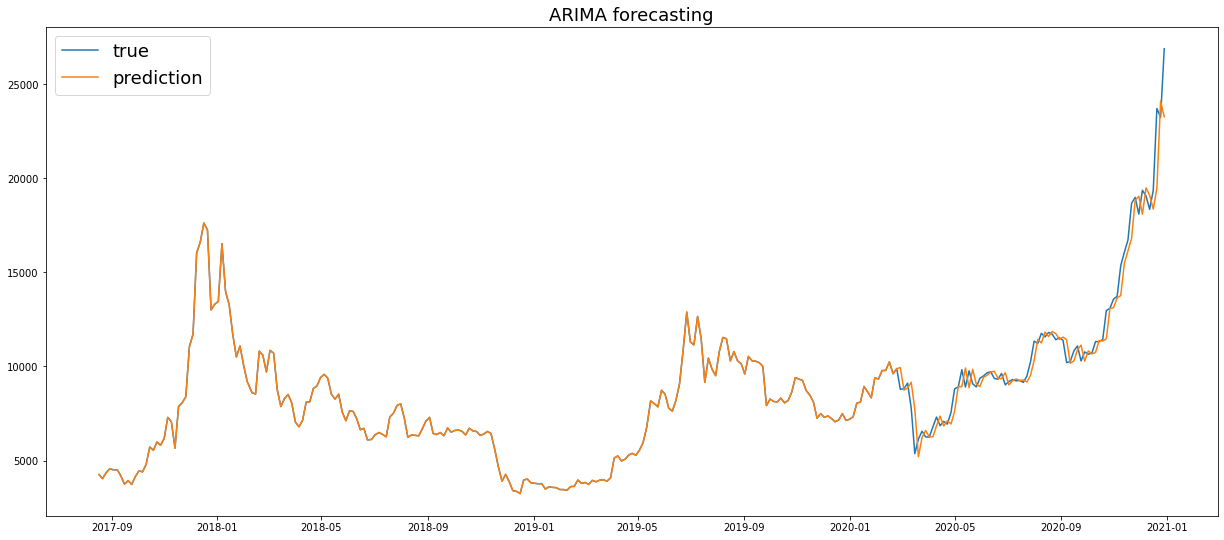

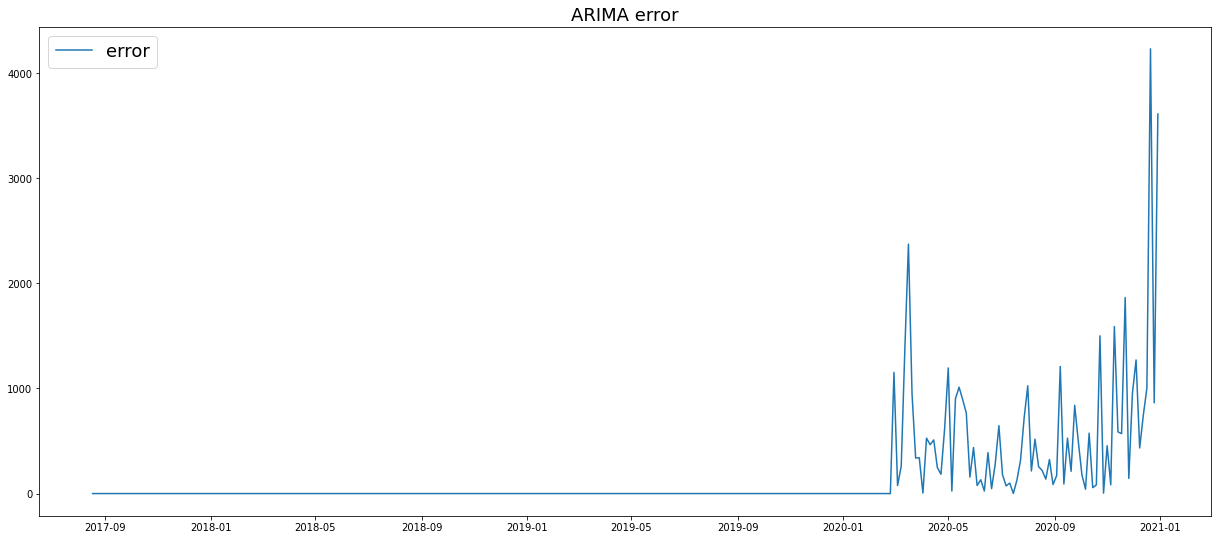

In [9]:
train, test = train_test_split(df.open[::100], test_size=0.25, shuffle=False)

size = len(test)
test = iter(test)

train = train.to_numpy()
arima_predict = train.copy()
arima_error = np.zeros_like(train)

for _ in range(size):
    model = ARIMA(train, order=arima_param).fit()
    
    arima_predict = np.append(arima_predict, model.forecast())

    true = next(test)
    
    arima_error = np.append(arima_error, np.abs(true - model.forecast()))
    train = np.append(train, true)
    
rmse_arima = np.sqrt(mean_squared_error(train, arima_predict))
print("RMSE: {0}".format(rmse_arima))

plt.rc("figure", figsize=(21, 9))
plt.plot(df.start[::100], train, label="true")
plt.plot(df.start[::100], arima_predict, label="prediction")
plt.legend(fontsize=18)
plt.title("ARIMA forecasting", fontsize=18)
plt.show()

plt.rc("figure", figsize=(21, 9))
plt.plot(df.start[::100], arima_error, label="error")
plt.legend(fontsize=18)
plt.title("ARIMA error", fontsize=18)
plt.show()

# 

### SARIMA

In [10]:
p = d = q = range(0, 3)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 2) for x in list(itertools.product(p, d, q))]

delta = np.inf

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(df.open[::100],
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)

            results = mod.fit()

            if results.aic < delta:
                    delta = results.aic
                    sarima_param = param
                    sarima_param_seasonal = param_seasonal
        except:
            continue

In [11]:
print("param = {0} \nseasonal param = {1}".format(sarima_param, sarima_param_seasonal))

param = (0, 2, 1) 
seasonal param = (0, 2, 2, 2)


RMSE: 453.048130020549


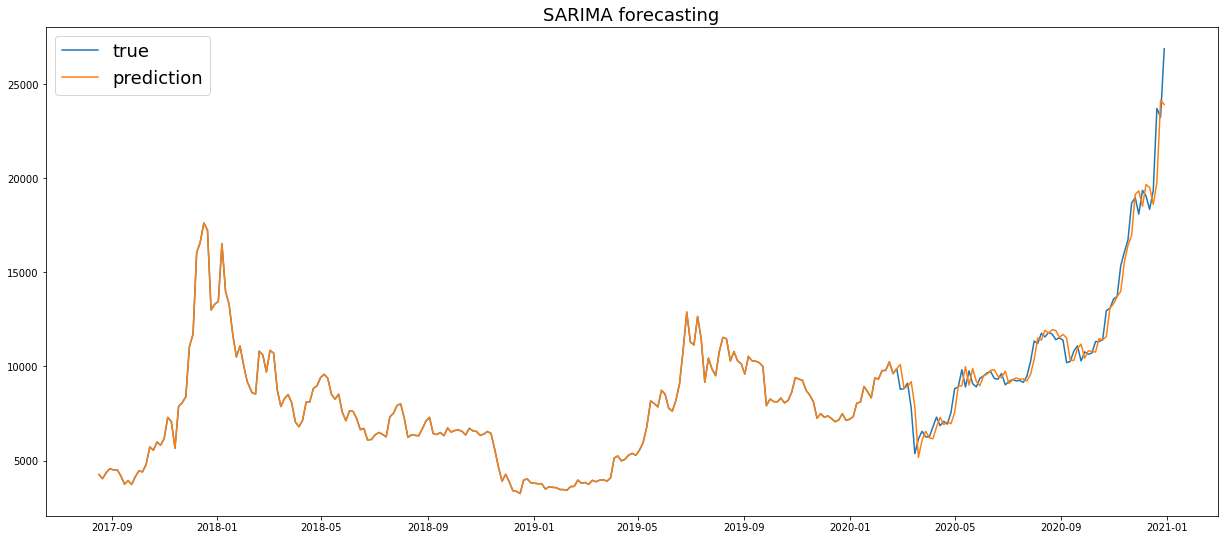

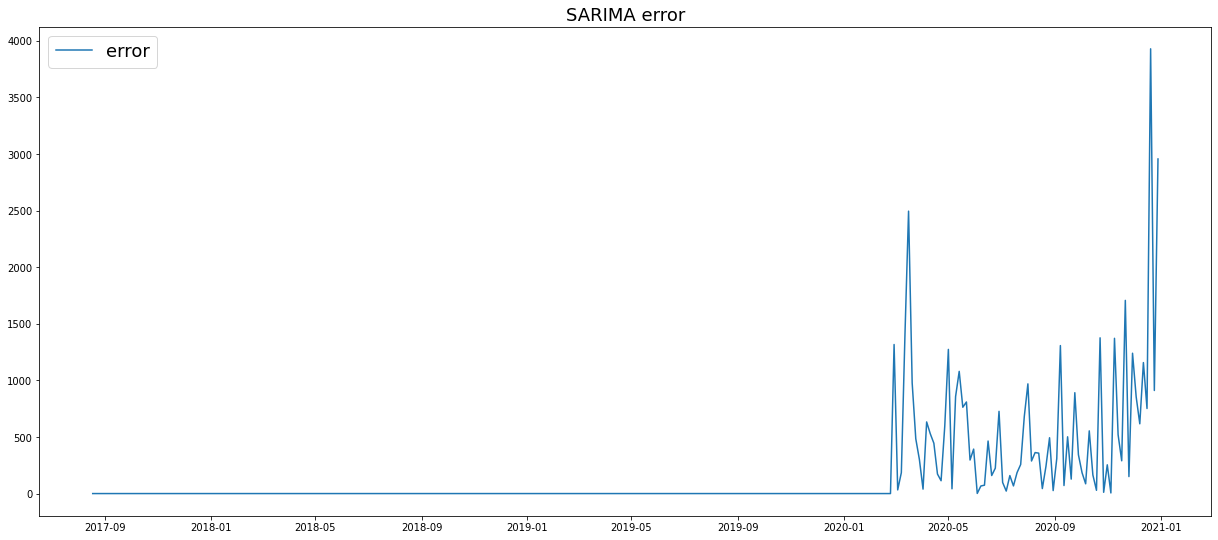

In [12]:
train, test = train_test_split(df.open[::100], test_size=0.25, shuffle=False)

size = len(test)
test = iter(test)

train = train.to_numpy()
sarima_predict = train.copy()
sarima_error = np.zeros_like(train)

for _ in range(size):
    model = SARIMAX(train, order=sarima_param, seasonal_order=sarima_param_seasonal).fit()
    
    sarima_predict = np.append(sarima_predict, model.forecast())

    true = next(test)
    
    sarima_error = np.append(sarima_error, np.abs(true - model.forecast()))
    train = np.append(train, true)
        
rmse_sarima = np.sqrt(mean_squared_error(train, sarima_predict))
print("RMSE: {0}".format(rmse_sarima))

plt.rc("figure", figsize=(21, 9))
plt.plot(df.start[::100], train, label="true")
plt.plot(df.start[::100], sarima_predict, label="prediction")
plt.legend(fontsize=18)
plt.title("SARIMA forecasting", fontsize=18)
plt.show()

plt.rc("figure", figsize=(21, 9))
plt.plot(df.start[::100], sarima_error, label="error")
plt.legend(fontsize=18)
plt.title("SARIMA error", fontsize=18)
plt.show()

# 

### Compare

In [13]:
print("ARMA RMSE: {0}".format(rmse_arma))
print("ARIMA RMSE: {0}".format(rmse_arima))
print("SARIMA RMSE: {0}".format(rmse_sarima))

ARMA RMSE: 506.95110683726153
ARIMA RMSE: 477.8083621040456
SARIMA RMSE: 453.048130020549


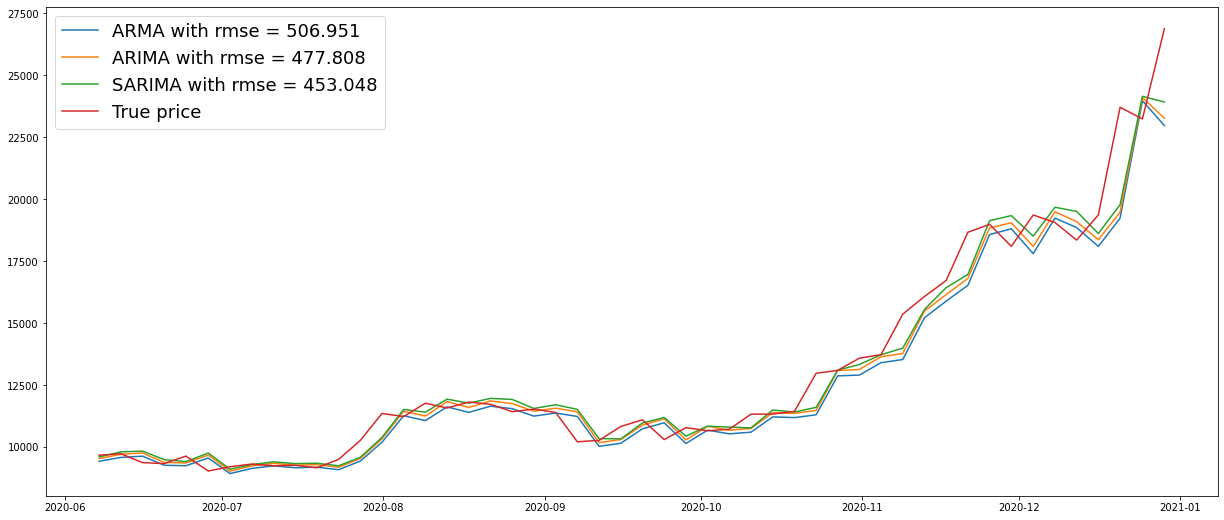

In [14]:
time = df.start[::100][-50::]
true_plot = df.open[::100][-50::]
arma_plot = arma_predict[-50::]
arima_plot = arima_predict[-50::]
sarima_plot = sarima_predict[-50::]

plt.rc("figure", figsize=(21, 9))
plt.plot(time, arma_plot, label="ARMA with rmse = {0}".format(round(rmse_arma, 3)))
plt.plot(time, arima_plot, label="ARIMA with rmse = {0}".format(round(rmse_arima, 3)))
plt.plot(time, sarima_plot, label="SARIMA with rmse = {0}".format(round(rmse_sarima, 3)))
plt.plot(time, true_plot, label="True price")

plt.legend(fontsize=18)
plt.show()

All models are almost the same, but RMSE value for SARIMA is the lowest.